In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import seaborn as sns
from random import randint

In [2]:
data_src = "/kaggle/input/state-farm-distracted-driver-detection"

In [3]:
train_df = pd.read_csv(f"{data_src}/driver_imgs_list.csv")
sample_submission_df = pd.read_csv(f"{data_src}/sample_submission.csv")


In [4]:
train_df['path'] = train_df.apply(lambda row: f"{data_src}/imgs/train/{row['classname']}/{row['img']}", axis=1)
print(train_df.head())


  subject classname            img  \
0    p002        c0  img_44733.jpg   
1    p002        c0  img_72999.jpg   
2    p002        c0  img_25094.jpg   
3    p002        c0  img_69092.jpg   
4    p002        c0  img_92629.jpg   

                                                path  
0  /kaggle/input/state-farm-distracted-driver-det...  
1  /kaggle/input/state-farm-distracted-driver-det...  
2  /kaggle/input/state-farm-distracted-driver-det...  
3  /kaggle/input/state-farm-distracted-driver-det...  
4  /kaggle/input/state-farm-distracted-driver-det...  


In [5]:
sample_submission_df.head(5)

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


**Class mapping**

In [6]:
class_mapping = {'c0': 'safe driving', 
                'c1': 'texting - right', 
                'c2': 'talking on the phone - right', 
                'c3': 'texting - left', 
                'c4': 'talking on the phone - left', 
                'c5': 'operating the radio', 
                'c6': 'drinking', 
                'c7': 'reaching behind', 
                'c8': 'hair and makeup', 
                'c9': 'talking to passenger'}


**Basic EDA**

In [7]:
print('Number of samples:', len(train_df))
print('Number of classes:', train_df['classname'].nunique())
print('Number of images per class:', train_df['classname'].value_counts())


Number of samples: 22424
Number of classes: 10
Number of images per class: classname
c0    2489
c3    2346
c4    2326
c6    2325
c2    2317
c5    2312
c1    2267
c9    2129
c7    2002
c8    1911
Name: count, dtype: int64


In [8]:
# Check for missing data
print('Missing values in each column:')
print(train_df.isnull().sum())


Missing values in each column:
subject      0
classname    0
img          0
path         0
dtype: int64


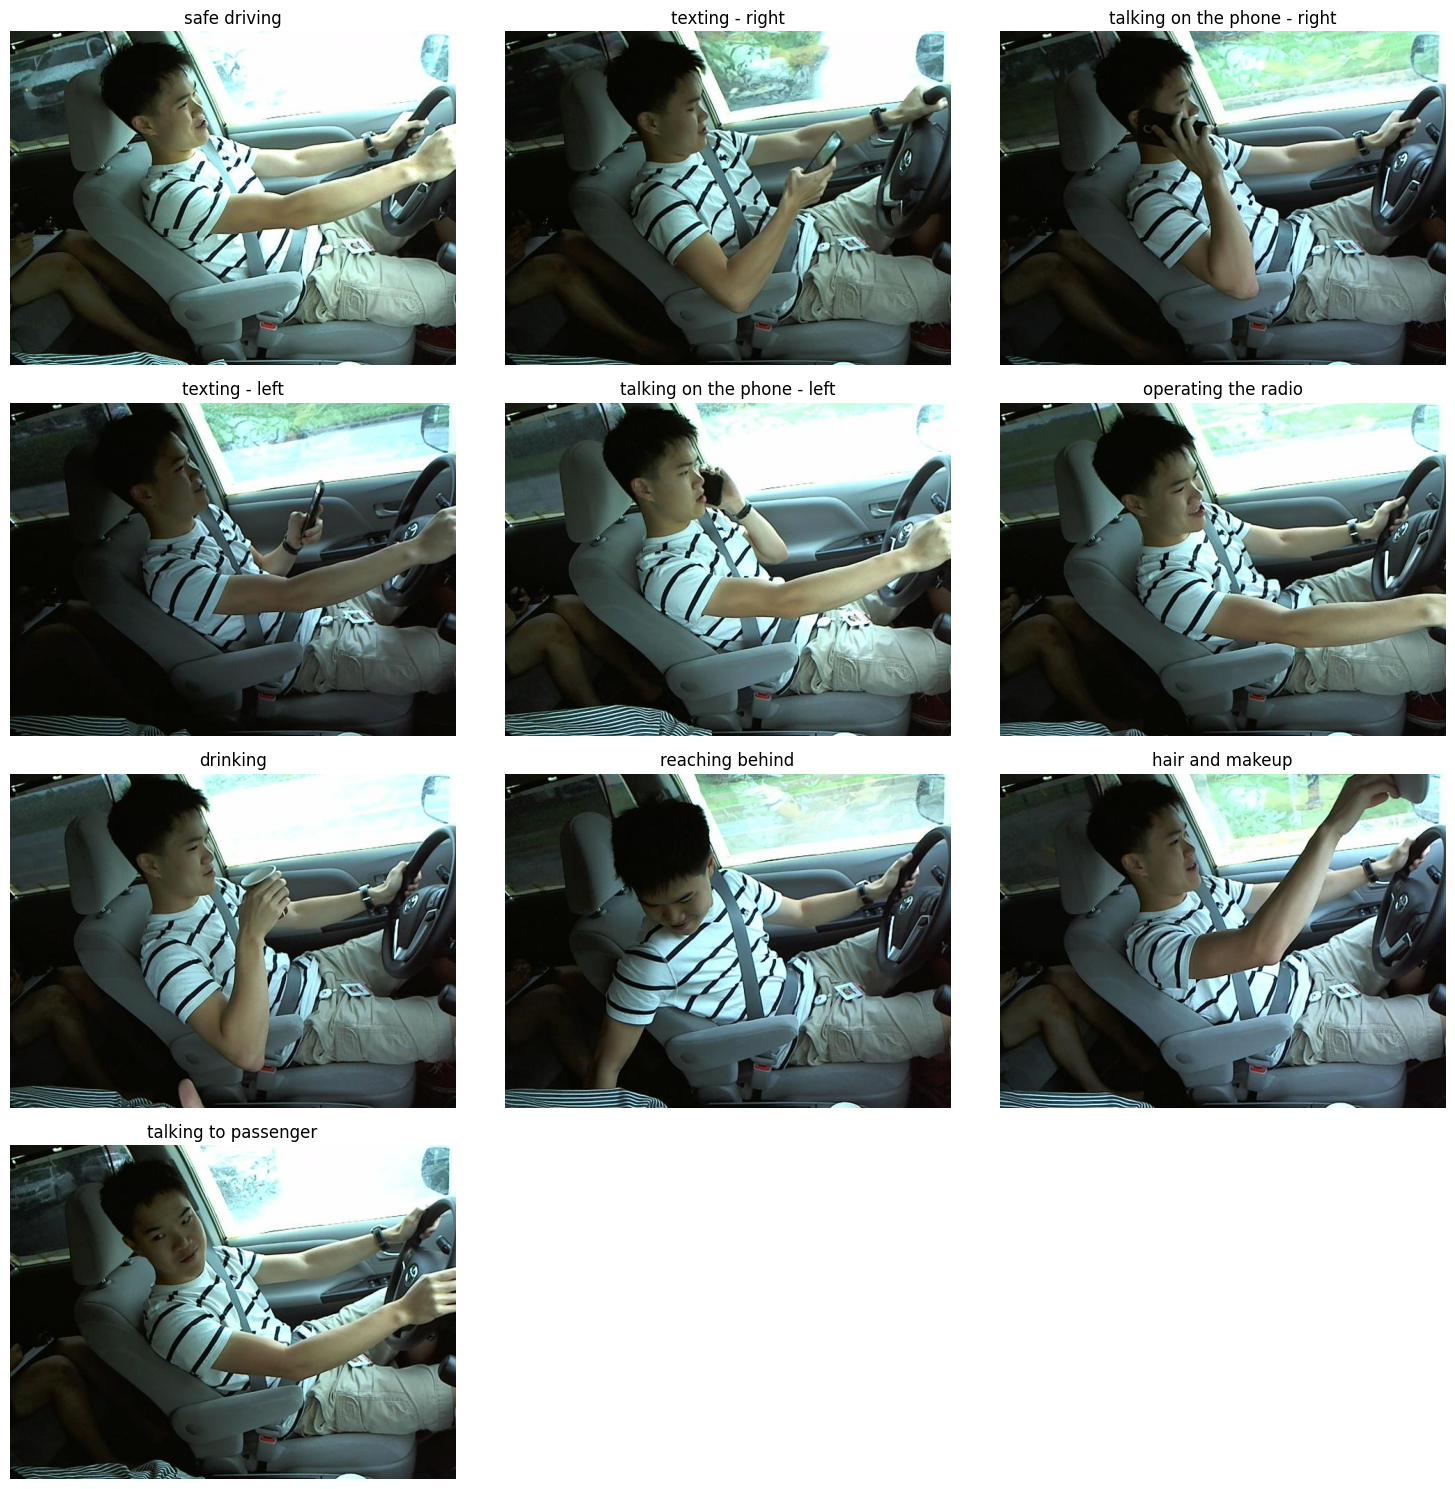

In [9]:
def visualize_images(dataframe, class_names):
    plt.figure(figsize=(15, 15))
    for class_code, class_name in class_names.items():
        plt.subplot(4, 3, int(class_code[-1]) + 1)
        img_path = dataframe[dataframe['classname'] == class_code].iloc[0]['path']
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_images(train_df, class_mapping)


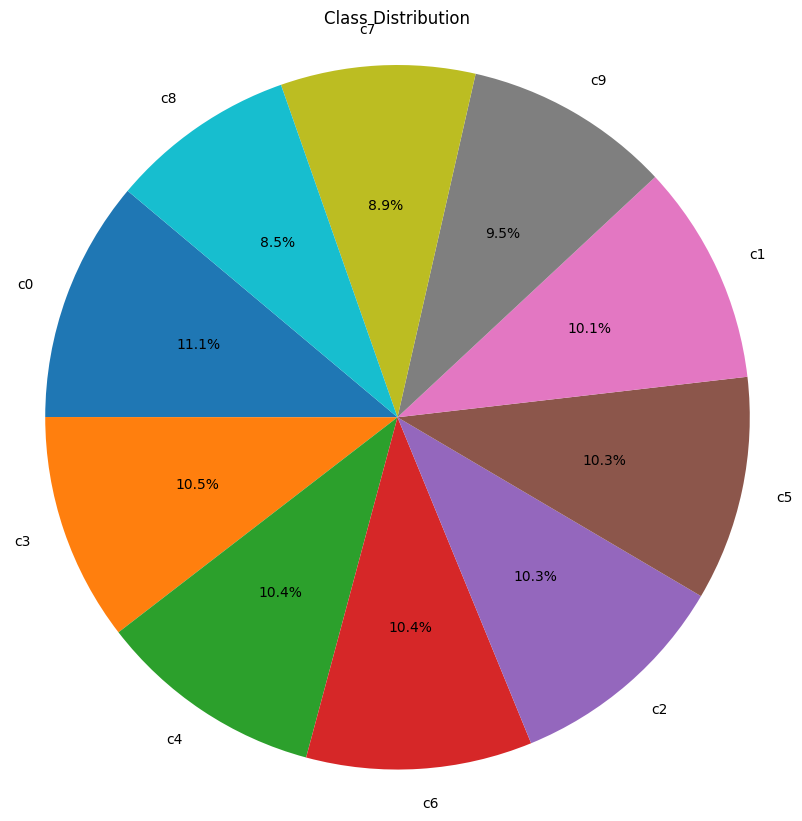

In [14]:
# First, get the counts of each class
class_counts = train_df['classname'].value_counts()

# Now, plot these counts as a pie chart
plt.figure(figsize=(10, 10))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Class Distribution')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Even though the classes c7,c8, c9 looks unevenly distributed when compared to others, there is n significant class imbalance

In [17]:
print(train_df['subject'].unique())

['p002' 'p012' 'p014' 'p015' 'p016' 'p021' 'p022' 'p024' 'p026' 'p035'
 'p039' 'p041' 'p042' 'p045' 'p047' 'p049' 'p050' 'p051' 'p052' 'p056'
 'p061' 'p064' 'p066' 'p072' 'p075' 'p081']


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


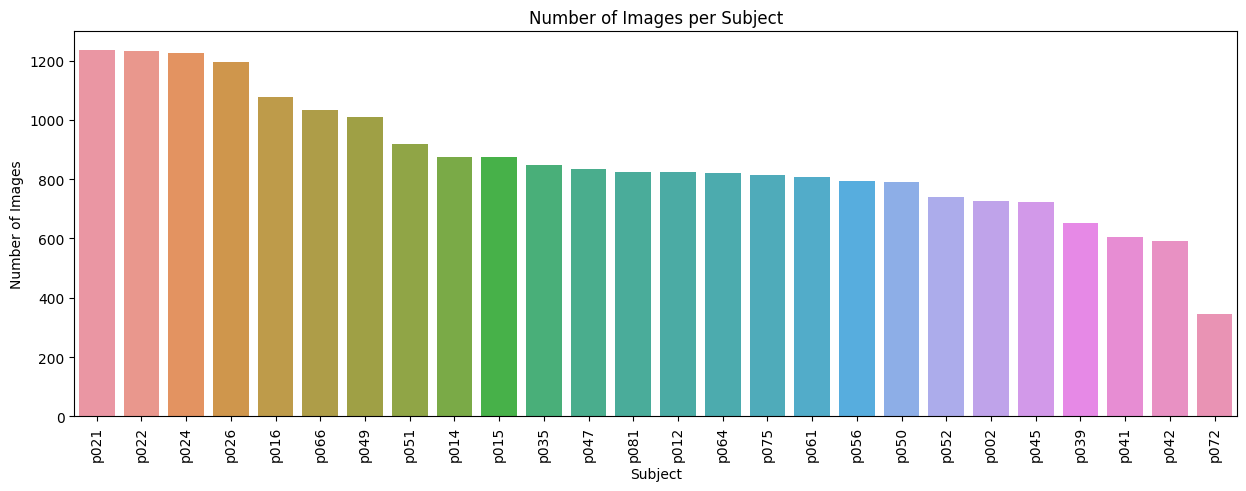

In [15]:
# Plotting images per subject
plt.figure(figsize=(15, 5))
subject_counts = train_df['subject'].value_counts()
sns.barplot(x=subject_counts.index, y=subject_counts.values)
plt.title('Number of Images per Subject')
plt.ylabel('Number of Images')
plt.xlabel('Subject')
plt.xticks(rotation=90)
plt.show()


* The bar graph shows an imbalanced distribution of images across subjects, with subjects like p021 having the most images, which could lead to model bias and overfitting towards more represented subjects.
* Subjects like p072 are underrepresented, potentially leading to poor model generalization for these individuals, and stratified sampling may be necessary to ensure fair and balanced model training and validation.

Building Baseline CNN model

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [21]:
image_paths = train_df['path'].values
image_labels = train_df['classname'].astype('category').cat.codes.values  # Integer encoding of the labels


In [22]:
X_train_paths, X_val_paths, y_train, y_val = train_test_split(image_paths, image_labels, test_size=0.2, random_state=42)

In [26]:
def load_images(paths):
    images = []
    for path in paths:
        img = Image.open(path).convert('RGB')
        img = img.resize((64, 64))  # Resize images to 64x64 for the baseline model
        img = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
        images.append(img)
    return np.array(images)


In [27]:
X_train = load_images(X_train_paths)
X_val = load_images(X_val_paths)

In [29]:
model = tf.keras.Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(train_df['classname'].nunique()))  # Number of unique classes
model.add(Activation('softmax'))


In [30]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [34]:
batch_size = 32
epochs = 10

model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    verbose=2
)

Epoch 1/10
560/560 - 35s - loss: 1.7550 - accuracy: 0.3443 - val_loss: 0.9313 - val_accuracy: 0.6627 - 35s/epoch - 62ms/step
Epoch 2/10
560/560 - 22s - loss: 1.0287 - accuracy: 0.6332 - val_loss: 0.4461 - val_accuracy: 0.8680 - 22s/epoch - 40ms/step
Epoch 3/10
560/560 - 22s - loss: 0.7009 - accuracy: 0.7562 - val_loss: 0.2665 - val_accuracy: 0.9206 - 22s/epoch - 40ms/step
Epoch 4/10
560/560 - 22s - loss: 0.5245 - accuracy: 0.8240 - val_loss: 0.1803 - val_accuracy: 0.9501 - 22s/epoch - 39ms/step
Epoch 5/10
560/560 - 22s - loss: 0.4195 - accuracy: 0.8591 - val_loss: 0.1393 - val_accuracy: 0.9583 - 22s/epoch - 40ms/step
Epoch 6/10
560/560 - 22s - loss: 0.3581 - accuracy: 0.8838 - val_loss: 0.1231 - val_accuracy: 0.9630 - 22s/epoch - 39ms/step
Epoch 7/10
560/560 - 22s - loss: 0.3115 - accuracy: 0.8978 - val_loss: 0.1098 - val_accuracy: 0.9688 - 22s/epoch - 39ms/step
Epoch 8/10
560/560 - 22s - loss: 0.2838 - accuracy: 0.9069 - val_loss: 0.1117 - val_accuracy: 0.9679 - 22s/epoch - 40ms/step
